### Natural Language Understanding Challenge

To begin with - Due to the short timeframe, I wasn't able to refactor / beautify my code to the extent I would've liked. 

As I wrote more lines of code and iterated between several ideas, the complexity increased - and so my code might look a little off. Also, pardon the variable names if they are confusing. 

My production-grade code is usually a lot cleaner than this. :)

###### Data preparation and cleaning - the cornerstone of any NLP task

In [25]:
# Importing all necessary stuff

import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
class DataGetter():
    
    """ This is a class that loads and transforms data so it can be immediately usable with just the appropriate
    method calls.
    
    Also has attributes that contain extracted data.
    """
    
    
    def __init__(self, filename):
        
        self.df = pd.read_json(filename)
        
        self.df['text'] = None
        self.df['intent'] = None
        self.df['entities'] = None
        self.df['training'] = None
        
        for index, row in self.df.iterrows():
            for key, value in self.df.iloc[index].sentences.items():
                self.df.iloc[index][key] = value
            
    
    
    
    
    def get_sentences(self):
        
        """ Returns a list of sentences in plain text
        """
        self.sentences = self.df.text.tolist()
        return self.sentences





    def clean_and_tokenise(self):   
        
        """ Returns a list of tokenised and cleaned sentences
        """
        
        self.get_sentences()
        
        """Removes '!', and '.' punctuations from sentence strings
        """
        for i, sent in enumerate(self.sentences):
            self.sentences[i] = re.sub('[.!]+', "", sent)            
            
        """ Splits string based on (- ' : , and ?). Deduced this list by looking at the start-stop indices
            at various examples
        """
        self.sentences_tokenised = list(map(lambda x: re.split(" |(-)|'|(:)|(,)|(\?)", x), self.sentences))
        
        for i, sent in enumerate(self.sentences_tokenised):
            self.sentences_tokenised[i] = list(filter(None, sent))
            
        return self.sentences_tokenised
            


    
    def get_unique_entities(self):
        """Returns list of unique entities"""
        self.unique_ents = list(set([dict_['entity'] for sentence in self.df.entities for dict_ in sentence]))
        return self.unique_ents

        
    def get_unique_intents(self):
        """Returns list of unique intents"""
        self.unique_intents = list(set(self.df.intent))
        return self.unique_intents
        
    
    def get_entities(self):
        """Returns matching entity for every word"""
        
        self.clean_and_tokenise()
        
        self.entitites_start_stop = df.entities.apply(lambda x: [(w['start'], w['stop']) for w in x])
    
        self.entity_sequence = list(map(lambda x: ['O' for word in x], self.sentences_tokenised))
        

        for i, sent in enumerate(self.sentences_tokenised):
            for ent in self.df.iloc[i].entities:
                start = ent['start']
                stop = ent['stop']
                
                entity = ent['entity']
                                
                
                self.entity_sequence[i][start:stop+1] = [entity for i in 
                                                         range(len(self.entity_sequence[i][start:stop+1]))]


        return self.entity_sequence

In [3]:
# Instantiating class
data = DataGetter('ChatbotCorpus.json')

# Getting the DataFrame object
df = data.df

# Getting unique entities in the corpus
unique_entities = data.get_unique_entities()

# Getting cleaned and tokenised sentences
sentences = data.clean_and_tokenise()

# Getting entities
entities = data.get_entities()



It is at this point that I noticed that for some sentences, the 'start' and 'stop' values for their entities is one value higher. For example, if 'start' should be 3, it is 4. 

This misaligns the word-entity pair by one place. I had to fix this before proceeding.

For example, look at the sentence at index 33.

quiddestraße should have an entity value of StationStart but there is a mismatch by one place. In fact, all entities in this sentence are.

In [4]:
for i, j in zip(sentences[33], entities[33]):
    print(i, j)

what O
s O
the O
shortest O
way Criterion
from O
quiddestraße O
to StationStart
odeonsplatz O
? StationDest


###### Let's redo entity extraction.

We mark words without entities as 'O', meaning 'no entity'

In [5]:

entities = list(map(lambda x: ['O' for word in x], sentences))

In [6]:
def fix_faulty(sentences, df, entities):
    
    """ Fixes faulty entity labelling (a data artifact)
    
    Args:
        sentences -> list of tokenised sentences
        df -> DataFrame generated from the input JSON
        entities -> list of entities for every word in every sentence
        
    Returns:
        entities -> list of entities for every word in every sentence (corrected)
        
    Raises:
        IndexError - when there is length mismatch between inputs
    """

    faulty_points = []

    for i, sent in enumerate(sentences):
        for ent in df.iloc[i].entities:
            start = ent['start']
            stop = ent['stop']
            text = ent['text']

            entity = ent['entity']

            text = re.split(" |(-)|'|(:)|(,)", text)

            if not any(set(sentences[i][start:stop+1]) & set(text)):
                faulty_points.append(i)
                break

            len_entity = len(entities[i][start:stop+1])
            newlist = [entity] * len_entity
            entities[i][start:stop+1] = newlist


    for i in faulty_points:

        for ent in df.iloc[i].entities:

            start = ent['start'] - 1
            stop = ent['stop'] - 1

            entity = ent['entity']

            sentences[i][start:stop+1]

            len_entity = len(entities[i][start:stop+1])

            newlist = [entity] * len_entity
            entities[i][start:stop+1] = newlist
            
    return entities

In [7]:
entities = fix_faulty(sentences, df, entities)

We fixed the problem now

In [8]:
for i, j in zip(sentences[33], entities[33]):
    print(i, j)

what O
s O
the O
shortest Criterion
way O
from O
quiddestraße StationStart
to O
odeonsplatz StationDest
? O


Generating word, entity pairs for each sentence

In [9]:
def word_ent_pairs(sentences, entities):
    
    """ Generates (word, entity) pairs for each sentence.
    
    
    Args:
        sentences -> list of tokenised sentences
        entities -> list of entities for every word in every sentence
        
    Returns:
        sent_ents -> (word, entity) pair
        
    Raises:
        IndexError - if sentences and entities are not of the same size
  
  """
    

    sent_ents = []

    for i, sent in enumerate(sentences):

        word_ent = []
        for word, ent in zip(sent, entities[i]):
            word_ent.append((word, ent))

        sent_ents.append(word_ent)
    
    return sent_ents

In [10]:
sent_ents = word_ent_pairs(sentences, entities)

In [13]:
# Putting the above in a DataFrame

corpus = []

for sent in df.entities:
    
    for dict_ in sent:
        word = dict_['text']
        ent = dict_['entity']
    corpus.append((word, ent))
    
corpus_df = pd.DataFrame(corpus, columns=["word", "ent"])

1) Intent Categorisation

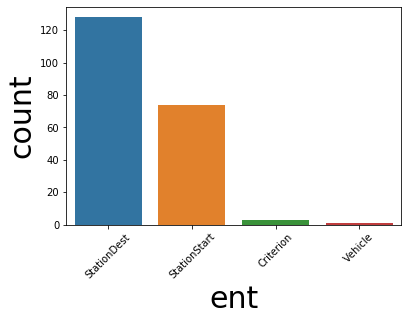

In [26]:
ent_plot = sns.countplot(corpus_df['ent'])
plt.xticks(rotation=45);

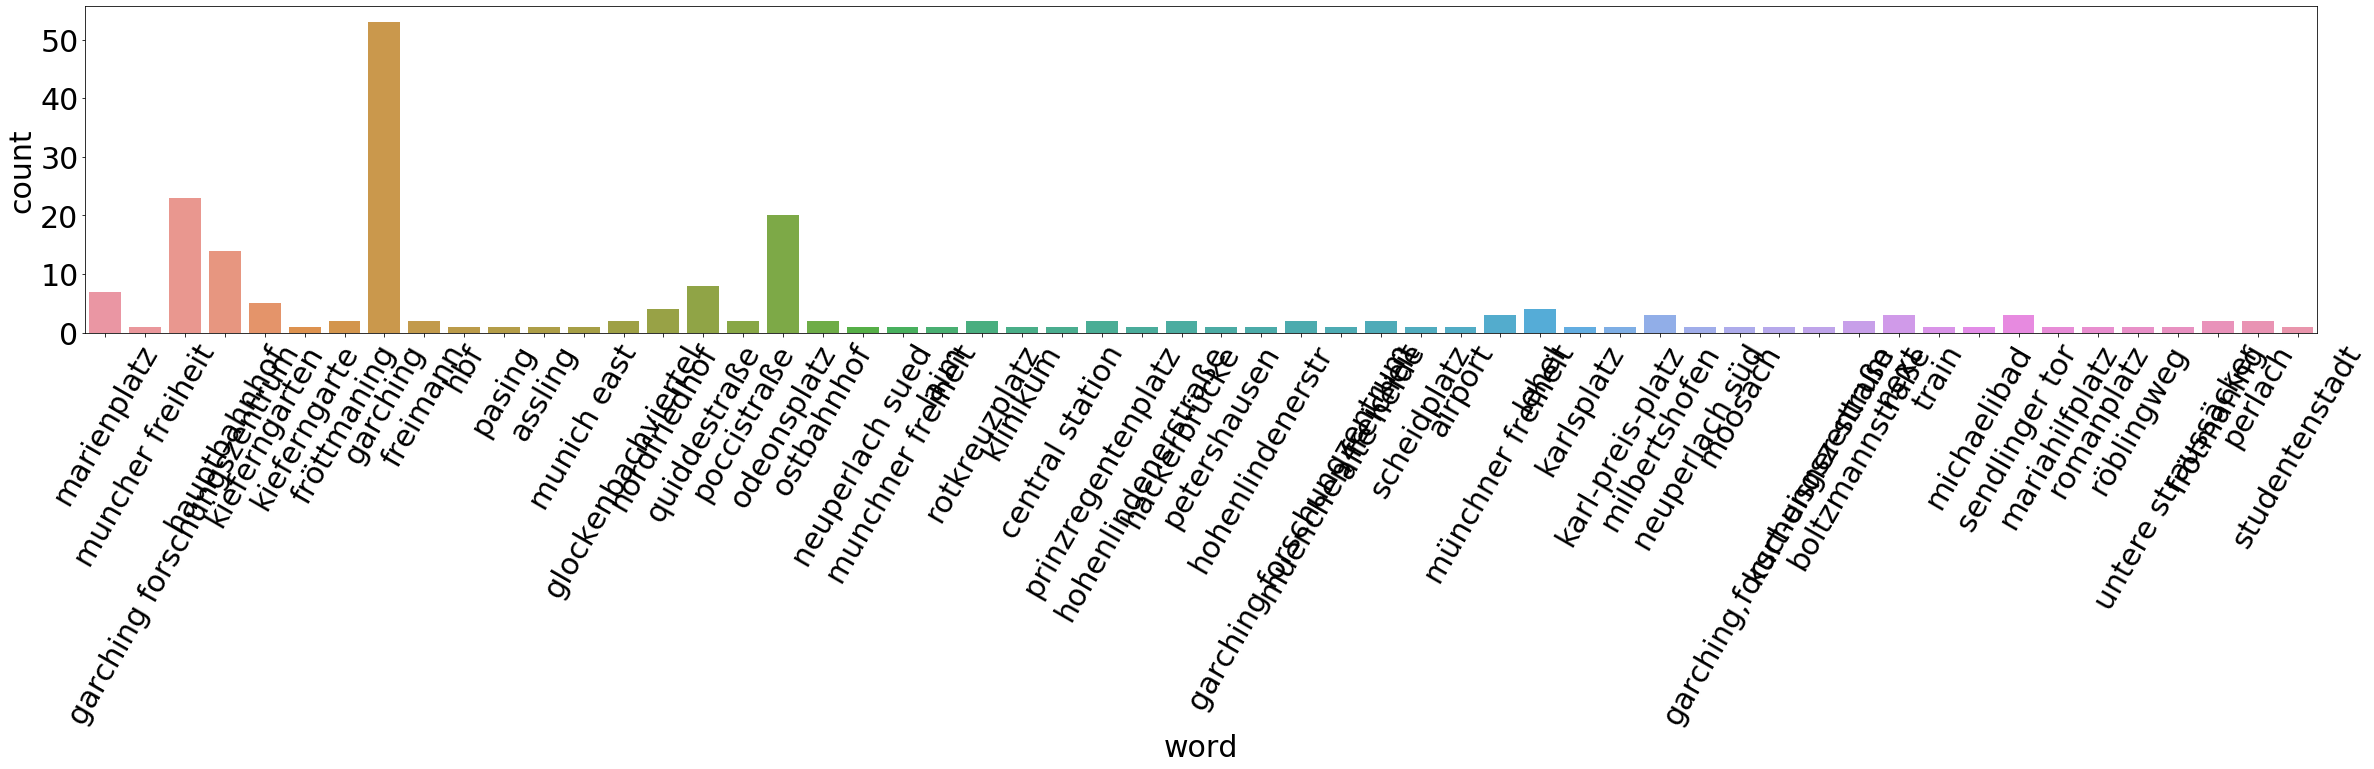

In [30]:
plt.figure(figsize=(40, 6));
word_plot = sns.countplot(corpus_df['word'])
plt.xticks(rotation=60, fontsize=30);
plt.yticks(fontsize=30);
